In [1]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import numpy as np


In [2]:
# --- 1. CONFIGURACIÓN INICIAL ---
# ==========================================================
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "compartido/multi_pretext_model2.ckpt"
MODEL_PATH = "/lustre/home/mgortarez/MEDA_Challenge/models/221025MG_backbone.ssl.pth"

# Coloca la ruta a tu dataset de PRUEBA (con carpetas de clases)
DATASET='chestmnist'
PATH_DATASET = f"../.medmnist/{DATASET}.npz"

# ¿Cuántas clases tiene tu dataset de PRUEBA?
NUM_CLASES = 14

# Parámetros
BATCH_SIZE = 64
EPOCHS_DE_PRUEBA = 20
LEARNING_RATE = 0.0001
JIGSAW_N = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


In [3]:
# --- 4. Modelo Multi-Pretexto (Versión LightningModule) ---

class MultiPretextSSL_Lightning(pl.LightningModule):
    def __init__(self, backbone, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters('learning_rate') # Guarda lr
        self.backbone = backbone
        self.lr = learning_rate
        
        num_features = 512 # Salida de ResNet18
        
        # --- DECODER CORREGIDO PARA 28x28 ---
        decoder_layers_28x28 = [
            nn.ConvTranspose2d(num_features, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()
        ]
        
        self.color_head = nn.Sequential(*decoder_layers_28x28)
        self.patch_head = nn.Sequential(*decoder_layers_28x28)
        
        # --- JIGSAW HEAD CORREGIDO PARA N=4 (16 patches) ---
        self.n_patches = JIGSAW_N * JIGSAW_N # 16
        self.jigsaw_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_patches * self.n_patches) # 16*16 = 256
        )

    def forward(self, x, task="color"):
        feats = self.backbone(x)
        if task == "color":
            return self.color_head(feats)
        elif task == "patch":
            return self.patch_head(feats)
        elif task == "jigsaw":
            return self.jigsaw_head(feats)

    def training_step(self, batch, batch_idx):
        # batch es lo que retorna __getitem__, en este caso, 'imgs'
        imgs = batch
        
        # Elegir una tarea al azar
        task = random.choice(["color", "patch", "jigsaw"])
        loss = 0.0

        if task == "color":
            inp, target = colorization_pair_tensor(imgs)
            pred = self(inp, "color")
            loss = F.mse_loss(pred, target)
        
        elif task == "patch":
            inp, target = patch_prediction_pair_tensor(imgs)
            pred = self(inp, "patch")
            loss = F.mse_loss(pred, target)
        
        elif task == "jigsaw":
            inp, target = jigsaw_pair_tensor(imgs, n=JIGSAW_N) # n=4
            pred = self(inp, "jigsaw") # Shape: [B, 256]
            
            # [B, 256] -> [B, 16, 16]
            pred_reshaped = pred.view(-1, self.n_patches, self.n_patches) 
            target_reshaped = target.view(-1) # [B*16]
            
            loss = F.cross_entropy(pred_reshaped.view(-1, self.n_patches), target_reshaped)

        # Loggear la pérdida. 'prog_bar=True' la muestra en la barra de progreso
        self.log(f'loss_{task}', loss, prog_bar=True)
        self.log('train_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [4]:
class MoCoLightning(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder_q = nn.Sequential(backbone)


In [5]:
resnet = models.resnet18(weights=None) 
# Tu backbone (quitando la capa FC final)
backbone_structure = nn.Sequential(*list(resnet.children())[:-1])

# Cargar el estado
encoder_wrapper = MoCoLightning(backbone=backbone_structure)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Cargar los pesos en la estructura
encoder_wrapper.encoder_q[0].load_state_dict(state_dict)

# --- Este es tu backbone listo para usar ---
ssl_backbone = encoder_wrapper.encoder_q[0].to(DEVICE)
print("Backbone cargado y movido a GPU.")

Backbone cargado y movido a GPU.


In [6]:
model = MultiPretextSSL_Lightning.load_from_checkpoint(PATH_MODELO_SSL, backbone=ssl_backbone)

# Congelar todo el backbone
for param in model.backbone.parameters():
    param.requires_grad = False

in_features = 512  # ResNet18 sin FC tiene 512 features
# Crear la cabeza lineal
linear_head = nn.Linear(in_features, NUM_CLASES)

class LinearProbingModel(nn.Module):
    def __init__(self, backbone, linear_head):
        super().__init__()
        self.backbone = backbone
        self.linear_head = linear_head

    def forward(self, x):
        feats = self.backbone(x)          # [B, 512, 1, 1]
        feats = feats.view(feats.size(0), -1)  # Flatten -> [B, 512]
        out = self.linear_head(feats)     # [B, NUM_CLASES]
        return out

model = LinearProbingModel(model.backbone, linear_head).to(DEVICE)



In [7]:
# Cargar archivo usando mmap para no cargar todo en memoria
data = np.load(PATH_DATASET)

# Revisar las llaves disponibles
print("Llaves en el .npz:", data.keys())

# Extraer imágenes y etiquetas (seguimos usando las mismas variables)
x_train = data["train_images"]      # shape (N, 28, 28), no carga todo en RAM
y_train = data["train_labels"].squeeze()
x_val = data["val_images"]
y_val = data["val_labels"].squeeze()
x_test = data["val_images"]
y_test = data["val_labels"].squeeze()

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")

Llaves en el .npz: KeysView(NpzFile '../.medmnist/chestmnist.npz' with keys: train_images, val_images, test_images, train_labels, val_labels...)
x_train: (78468, 28, 28), y_train: (78468, 14)
x_val: (11219, 28, 28), y_val: (11219, 14)


In [8]:
from torch.utils.data import Dataset, DataLoader

# --- 5. DEFINIR UN DATASET PERSONALIZADO PARA .NPZ ---

data_transform = transforms.Compose([
    transforms.Resize(224),               # redimensiona la imagen
    transforms.CenterCrop(224),           # recorta el centro
    transforms.ToTensor(),                # convierte a tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # normalización ImageNet
                         std=[0.229, 0.224, 0.225])
])


class BreastMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])
        # 🧠 Si el label es un array (como [1.]), conviértelo a escalar
        if isinstance(label, np.ndarray):
            label = label.item()  # equivalente a int(label[0])

        # Convertir de [H, W] a [H, W, 3] (porque el modelo espera RGB)
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)

        # Convertir a PIL y aplicar transformaciones (si existen)
        from PIL import Image
        img = Image.fromarray((img * 255).astype(np.uint8))  # pasar a 0–255

        if self.transform:
            img = self.transform(img)

        return img, label


# --- 6. CREAR DATASETS Y DATALOADERS ---

train_dataset = BreastMNISTDataset(x_train, y_train, transform=data_transform)
val_dataset = BreastMNISTDataset(x_val, y_val, transform=data_transform)
test_dataset = BreastMNISTDataset(x_test, y_test, transform=data_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"Dataset cargado. Tamaño train: {len(train_dataset)}, val: {len(val_dataset)}")


Dataset cargado. Tamaño train: 78468, val: 11219


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# --- ENTRENAR LA CABEZA LINEAL CON VALIDACIÓN ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.linear_head.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("Iniciando entrenamiento de la cabeza lineal (Linear Probing)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza finalizado.")


Iniciando entrenamiento de la cabeza lineal (Linear Probing)...


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_396816/176313544.py", line 25, in __getitem__
    label = int(self.labels[idx])
TypeError: only length-1 arrays can be converted to Python scalars


Evaluando en el set de validación...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉
   Accuracy en el set de testeo: 72.56 %


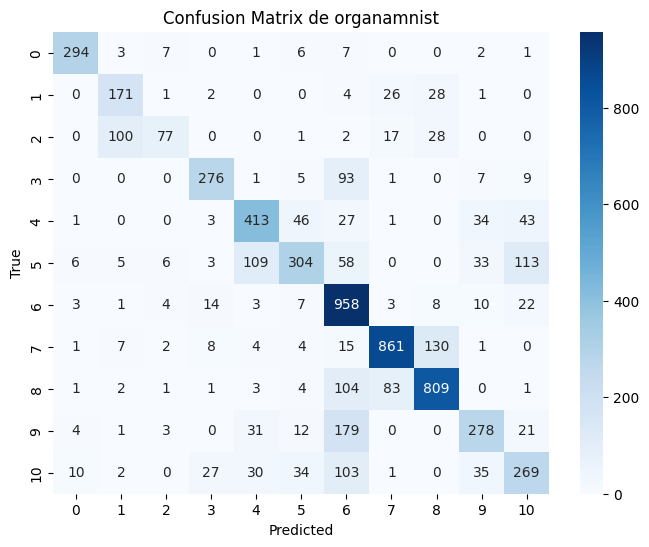

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 6. EVALUAR EL RENDIMIENTO ---
print("Evaluando en el set de validación...")

model.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- RESULTADO FINAL ---
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"   Accuracy en el set de testeo: {accuracy:.2f} %")
print("========================================================")

# --- MATRIZ DE CONFUSIÓN ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix de {DATASET}')
plt.show()


Extrayendo embeddings:   0%|                                                   | 0/102 [00:00<?, ?it/s]/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extrayendo embeddings: 100%|█████████████████████████████████████████| 102/102 [00:11<00:00,  9.17it/s]
/lustre/proyectos/p032/env/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Embeddings shape: (6491, 512)
Calculando t-SNE (puede tardar un par de minutos)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6491 samples in 0.001s...
[t-SNE] Computed neighbors for 6491 samples in 1.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6491
[t-SNE] Computed conditional probabilities for sample 2000 / 6491
[t-SNE] Computed conditional probabilities for sample 3000 / 6491
[t-SNE] Computed conditional probabilities for sample 4000 / 6491
[t-SNE] Computed conditional probabilities for sample 5000 / 6491
[t-SNE] Computed conditional probabilities for sample 6000 / 6491
[t-SNE] Computed conditional probabilities for sample 6491 / 6491
[t-SNE] Mean sigma: 1.576886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.141548
[t-SNE] KL divergence after 1000 iterations: 1.714997


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Etiquetas únicas: [ 0  1  2  3  4  5  6  7  8  9 10]


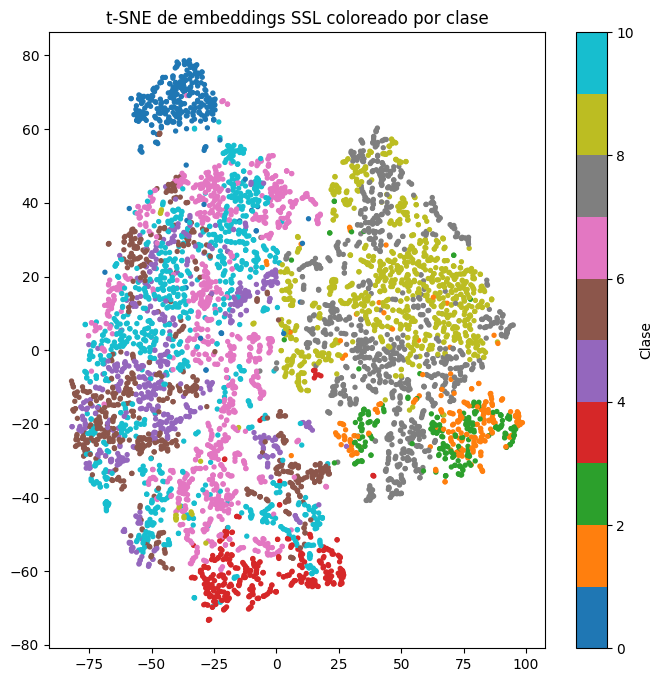

In [ ]:
# --- t-SNE sobre embeddings del backbone SSL ---

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 1️⃣ Preparamos solo el backbone (quitamos la cabeza fc)
backbone_ssl = nn.Sequential(*list(model.children())[:-1])  # quitar fc
backbone_ssl.eval().to(DEVICE)

# 2️⃣ Extraemos embeddings del conjunto de validación
all_embeddings = []

with torch.no_grad():
    for imgs, _ in tqdm(val_loader, desc="Extrayendo embeddings"):
        imgs = imgs.to(DEVICE)
        feats = backbone_ssl(imgs).squeeze()  # (B, 512, 1, 1) -> (B, 512)
        all_embeddings.append(feats.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)
print("Embeddings shape:", all_embeddings.shape)

# 3️⃣ Reducir dimensionalidad con t-SNE
print("Calculando t-SNE (puede tardar un par de minutos)...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, verbose=1)
emb_2d = tsne.fit_transform(all_embeddings)

# 4️⃣ Graficar

# Obtener todas las etiquetas de val_loader
all_labels = np.concatenate([y.numpy().ravel() for _, y in val_loader], axis=0)
print("Etiquetas únicas:", np.unique(all_labels))  # debería mostrar [0,1]

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab10", s=8)
plt.colorbar(label="Clase")
plt.title("t-SNE de embeddings SSL coloreado por clase")
plt.show()


Calculando UMAP (puede tardar unos segundos)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


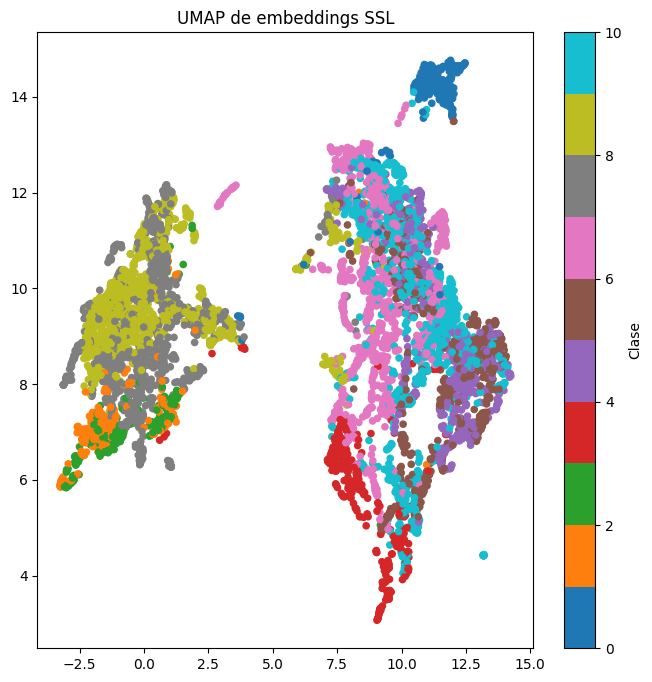

In [ ]:
# --- 3. UMAP ---
import umap
print("Calculando UMAP (puede tardar unos segundos)...")
umap_2d = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
emb_2d = umap_2d.fit_transform(all_embeddings)

# --- 4. GRAFICAR ---
plt.figure(figsize=(8,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab10", s=20)
plt.colorbar(label="Clase")
plt.title("UMAP de embeddings SSL")
plt.show()